In [1]:
import argparse
import pickle
import sys
import tomllib
import os

import datetime

from b2heavy.TwoPointFunctions.types2pts  import CorrelatorIO, Correlator, plot_effective_coeffs
from b2heavy.TwoPointFunctions.fitter import CorrFitter

In [2]:
import numpy  as np
import gvar   as gv
import pandas as pd
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import lsqfit
import os
import sys
import h5py

Modify here for setting the specifics of the case

In [88]:
ens      = 'Coarse-1'
data_dir = '/Users/pietro/code/data_analysis/BtoD/Alex'
meson    = 'Dsst'
mom      = '100'
binsize  = 9

tag = f'{ens}_{meson}_{mom}'

io = CorrelatorIO(ens,meson,mom,PathToDataDir=data_dir)
corr = Correlator(io,jkBin=binsize)


# Effective mass and overlap factor

In [90]:
(X,meff,aeff), MEFF, AEFF, Mpr, Apr = corr.EffectiveCoeff(
    trange=TLIM, 
    smearing=['1S-1S','d-d','d-1S']
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


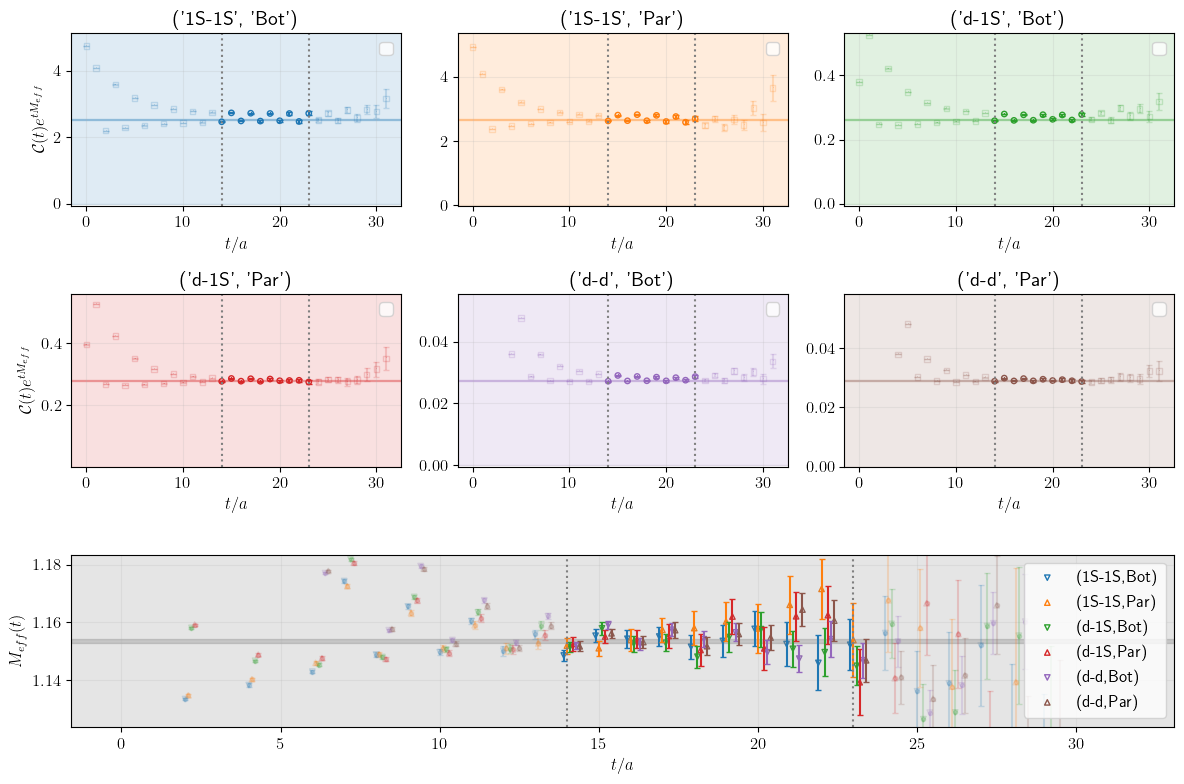

In [91]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12, 6 if len(np.unique([k[1] for k in X]))==1 else 8))

plot_effective_coeffs(TLIM,X,AEFF,aeff,Apr,MEFF,meff,Mpr,Aknob=1.)

plt.tight_layout()

# Play with priors

In [92]:
smlist = ['1S-1S','d-d','d-1S']
fitter = CorrFitter(corr, smearing=smlist)

In [93]:
np.log(AEFF['d-d','Par'])/2

-1.7696(20)

In [94]:
fitter.set_priors_phys(NEXC,Aeff=AEFF,Meff=MEFF)

{'E': [1.153(27), -1.66(57), -1.1(1.0), -1.1(1.0), -1.1(1.0), -1.1(1.0)],
 'Z_1S_Bot': [0.5(1.2), -1.2(1.2), 0.5(1.5), 0.5(1.5), 0.5(3.0), 0.5(3.0)],
 'Z_1S_Par': [0.5(1.2), -1.2(1.2), 0.5(1.5), 0.5(1.5), 0.5(3.0), 0.5(3.0)],
 'Z_d-1S_Bot': [0.5(1.7), 0.5(1.7), 0.5(1.7), 0.5(1.7)],
 'Z_d-1S_Par': [0.5(1.7), 0.5(1.7), 0.5(1.7), 0.5(1.7)],
 'Z_d_Bot': [-1.80(40), -3.0(1.5), 0.5(1.5), 0.5(1.5), 0.5(3.0), 0.5(3.0)],
 'Z_d_Par': [-1.77(40), -5.5(2.0), 0.5(1.5), 0.5(1.5), 0.5(3.0), 0.5(3.0)]}

In [95]:
PR = fitter.set_priors_phys(NEXC,Aeff=AEFF,Meff=MEFF)
PR['E'][0] = MEFF

for (sm,pol),v in AEFF.items():
    sm1,sm2 = sm.split('-')
    if sm1==sm2:
        k = f'Z_{sm1}_{pol}'
        prn = np.log(v)/2
        p = gv.gvar(prn.mean,prn.sdev*10)
        PR[k][0] = p

In [96]:
fitter = CorrFitter(corr,smearing=smlist)

fitter.fit(
    Nstates = NEXC,
    trange  = TLIM,
    priors  = PR,
    verbose = True
)

---------- 3+3 fit in (14, 23) for mes: Dsst of ens: Coarse-1 for mom: 100 --------------
 De-augmented chi2 = 59.39919042165192 with p-value = 9.907025948780308e-05
Least Square Fit:
  chi2/dof [dof] = 1.2 [60]    Q = 0.17    logGBF = 1527.1

Parameters:
            E 0    1.15313 (48)      [ 1.15349 (59) ]  
              1      -3.27 (34)      [   -1.66 (57) ]  **
              2      -1.65 (68)      [   -1.1 (1.0) ]  
              3      -1.61 (34)      [   -1.1 (1.0) ]  
              4      -1.16 (61)      [   -1.1 (1.0) ]  
              5      -1.14 (95)      [   -1.1 (1.0) ]  
     Z_1S_Bot 0     0.4771 (52)      [   0.463 (20) ]  
              1      -0.75 (10)      [   -1.2 (1.2) ]  
              2       0.24 (57)      [    0.5 (1.5) ]  
              3     0.05 (1.44)      [    0.5 (1.5) ]  
              4       0.2 (3.0)      [    0.5 (3.0) ]  
              5       0.5 (3.0)      [    0.5 (3.0) ]  
     Z_1S_Par 0     0.4969 (60)      [   0.489 (24) ]  
              

In [97]:
PR = fitter.set_priors_phys(NEXC,Meff=MEFF)
PR['E'][0] = MEFF

fitter = CorrFitter(corr,smearing=smlist)
fitter.fit(
    Nstates = NEXC,
    trange  = TLIM,
    priors  = PR,
    verbose = True
)

---------- 3+3 fit in (14, 23) for mes: Dsst of ens: Coarse-1 for mom: 100 --------------
 De-augmented chi2 = 59.59606163631395 with p-value = 9.333306969672052e-05
Least Square Fit:
  chi2/dof [dof] = 1.2 [60]    Q = 0.17    logGBF = 1514.9

Parameters:
            E 0    1.15327 (52)      [ 1.15349 (59) ]  
              1      -3.27 (34)      [   -1.66 (57) ]  **
              2      -1.60 (68)      [   -1.1 (1.0) ]  
              3      -1.61 (34)      [   -1.1 (1.0) ]  
              4      -1.16 (63)      [   -1.1 (1.0) ]  
              5      -1.14 (95)      [   -1.1 (1.0) ]  
     Z_1S_Bot 0     0.4786 (54)      [      0 ± 1.2 ]  
              1      -0.75 (10)      [   -1.2 (1.2) ]  
              2       0.17 (78)      [    0.5 (1.5) ]  
              3     0.05 (1.44)      [    0.5 (1.5) ]  
              4       0.2 (3.0)      [    0.5 (3.0) ]  
              5       0.5 (3.0)      [    0.5 (3.0) ]  
     Z_1S_Par 0     0.4987 (64)      [      0 ± 1.2 ]  
              

In [98]:
PR = fitter.set_priors_phys(NEXC)

fitter = CorrFitter(corr,smearing=smlist)
fitter.fit(
    Nstates = NEXC,
    trange  = TLIM,
    priors  = PR,
    verbose = True
)

---------- 3+3 fit in (14, 23) for mes: Dsst of ens: Coarse-1 for mom: 100 --------------
 De-augmented chi2 = 59.02830558251375 with p-value = 0.00011082860681497325
Least Square Fit:
  chi2/dof [dof] = 1.2 [60]    Q = 0.18    logGBF = 1508.8

Parameters:
            E 0     1.1525 (13)      [ 1.165 (28) ]  
              1      -3.28 (34)      [ -1.66 (57) ]  **
              2      -1.66 (67)      [ -1.1 (1.0) ]  
              3      -1.60 (33)      [ -1.1 (1.0) ]  
              4      -1.18 (63)      [ -1.1 (1.0) ]  
              5      -1.13 (95)      [ -1.1 (1.0) ]  
     Z_1S_Bot 0      0.472 (12)      [    0 ± 1.2 ]  
              1      -0.75 (10)      [ -1.2 (1.2) ]  
              2       0.34 (59)      [  0.5 (1.5) ]  
              3     0.05 (1.44)      [  0.5 (1.5) ]  
              4       0.3 (3.0)      [  0.5 (3.0) ]  
              5       0.5 (3.0)      [  0.5 (3.0) ]  
     Z_1S_Par 0      0.492 (12)      [    0 ± 1.2 ]  
              1      -0.92 (10)      [ 

# Explore fitrange

In [105]:
def Ndof(Npol,trange,nexc,Nsmr=2):
    Npar = 2*nexc + 2*nexc + 2*nexc + 2*(nexc-1)
    Npoints = Npol*(max(trange)-min(trange))
    return Npoints-Npar

#### Explore $t_\text{min}$

In [99]:
for tmax in corr.data.timeslice.values[15:]:
    x,Y = corr.format(trange=(tmax,tmax))
    print(tmax,end='   ')
    for (smr,pol),y in Y.items():
        err = abs(y[0].sdev/y[0].mean)
        print(round(err*100,1),end='         ')
    print('')


15   0.5         0.6         0.4         0.5         0.5         0.6         0.4         0.5         0.4         0.5         
16   0.7         0.8         0.5         0.5         0.5         0.7         0.5         0.6         0.5         0.6         
17   0.7         0.8         0.6         0.7         0.7         0.6         0.6         0.6         0.6         0.6         
18   0.9         1.0         0.7         0.8         0.8         0.9         0.7         0.8         0.7         0.8         
19   1.0         1.2         0.8         0.9         0.9         1.1         0.8         0.9         0.8         0.9         
20   1.2         1.6         0.9         1.0         1.2         1.4         1.0         1.1         1.0         1.1         
21   1.5         1.9         1.1         1.4         1.3         1.7         1.2         1.3         1.2         1.3         
22   1.8         2.3         1.4         1.6         1.7         1.9         1.4         1.6         1.4         1.6  

#### Explore $t_\text{max}$ and $N_\text{exc}$

In [107]:
for nstates in [1,2,3]:
    for tmin in np.arange(7,18):
        trange = (tmin,max(TLIM))

        try:
            fitter.fit(
                Nstates=nstates,
                trange=trange,
                verbose=False,
                pval=True,
                priors = fitter.set_priors_phys(nstates,Meff=MEFF)
            )
        except ValueError:
            print(nstates,tmin)

        Npar    = len(np.concatenate(list(fitter.set_priors_phys(nstates).values())))
        Npoints = len(fitter.fits[nstates,trange].y)
        chi2red = fitter.fits[nstates,trange].chi2red



        print(f'-------------- {nstates} - {tmin} [{round(chi2red,1)}/{Npoints-Npar}]={round(chi2red/(Npoints-Npar),1)}--------------- ')

Fit for (1, (7, 23)) has already been performed. Returning...
-------------- 1 - 7 [368004.3/92]=4000.0--------------- 
Fit for (1, (8, 23)) has already been performed. Returning...
-------------- 1 - 8 [56390.6/86]=655.7--------------- 
Fit for (1, (9, 23)) has already been performed. Returning...
-------------- 1 - 9 [4174.4/80]=52.2--------------- 
Fit for (1, (10, 23)) has already been performed. Returning...
-------------- 1 - 10 [1336.4/74]=18.1--------------- 
Fit for (1, (11, 23)) has already been performed. Returning...
-------------- 1 - 11 [936.1/68]=13.8--------------- 
Fit for (1, (12, 23)) has already been performed. Returning...
-------------- 1 - 12 [558.1/62]=9.0--------------- 
Fit for (1, (13, 23)) has already been performed. Returning...
-------------- 1 - 13 [433.3/56]=7.7--------------- 
Fit for (1, (14, 23)) has already been performed. Returning...
-------------- 1 - 14 [226.4/50]=4.5--------------- 
Fit for (1, (15, 23)) has already been performed. Returning...


In [100]:
klist = None
# klist = [k for k in fitter.fits if not (k[0]==3 or k[0]==2 and k[1][0]==14)]
klist = [k for k in fitter.fits if not (k[0]==1)]
e0,syst = fitter.model_average(keylist=klist)

KeyError: (2, (14, 23))

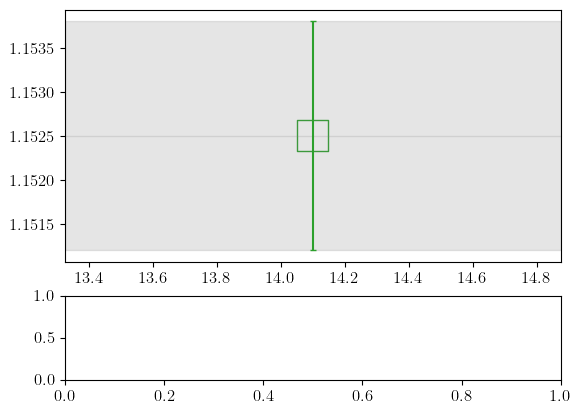

In [101]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, (ax, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
# f, ax = plt.subplots(1, 1)


pnorm = sum([fit.pvalue for fit in fitter.fits.values()])

# ============================================= PLOT ENERGY VALUES =============================================
# Energy plot for different tmin and Nexc
for nexc in [1,2,3]:
    E0 = [f.p['E'][0] for k,f in fitter.fits.items() if k[0]==nexc]
    pvaln = [f.pvalue for k,f in fitter.fits.items() if k[0]==nexc]/pnorm*500
    xplot = np.array([k[1][0] for k,f in fitter.fits.items() if k[0]==nexc])
    yplot = gv.mean(E0)
    yerr  = gv.sdev(E0)

    ax.scatter( xplot+(-0.1 + 0.1*(nexc-1)), yplot, marker='s', s=pvaln ,facecolors='none', edgecolors=f'C{nexc-1}')
    ax.errorbar(xplot+(-0.1 + 0.1*(nexc-1)), yplot, yerr=yerr, fmt=',' ,color=f'C{nexc-1}', capsize=2)
    ax.errorbar([], [], yerr=[], fmt='s' ,color=f'C{nexc-1}', capsize=2, label=f'{nexc}+{nexc}')

# Plot model average
ax.axhspan(e0.mean+e0.sdev,e0.mean-e0.sdev,color='gray',alpha=0.2,label=r'Model average of $E_0$')
ax.axhspan(e0.mean+syst,e0.mean-syst,color='gray',alpha=0.2)

# Plot prior
Epr = fitter.fits[2,TLIM].prior['E'][0]
# ax.axhspan(Epr.mean+Epr.sdev,Epr.mean-Epr.sdev,color='black',alpha=0.2,label='prior')
ax.axhline(Epr.mean,alpha=0.1,color='gray')


# Plot final tmin line
ax.axvline(min(TLIM),color='gray',linestyle=':')


# Limits in y
# ax.set_ylim(ymax=1.38,ymin=1.36)

ax.grid(alpha=0.5)
ax.set_xlabel(r'$t_{min}/a$')
ax.set_ylabel(r'$E_0$')
ax.legend()

ax.set_title(tag)


# ======================================= PLOT WEIGHTS =======================================
a1.grid(alpha=0.2)

norm = sum([fitter.weight(nexc,trange) for (nexc,trange),fit in fitter.fits.items()])

for nexc in [1,2,3]:
    x = [min(trange) for (n,trange),f in fitter.fits.items() if n==nexc]
    w = [fitter.weight(*k)/norm for k,f in fitter.fits.items() if k[0]==nexc]
    a1.scatter(x,w)
    a1.plot(x,w,alpha=0.2)

a1.set_ylim(ymin=0,ymax=1)

#### Final results for energy

In [102]:
e0_syst = gv.gvar(e0.mean,syst) 
print(f'E_0 for ens. {ens}, meson {meson} at mom {mom} is  {e0} [syst. {e0_syst}]\n')

with open('modav.dat','a') as w:
    w.write(f'E_0 for ens. {ens}, meson {meson} at mom {mom} is  {e0} [syst. {e0_syst}]\n')

E_0 for ens. Coarse-1, meson Dsst at mom 100 is  1.1525(13) [syst. 1.1525(0)]



# Domande
- gli errori dentro `format` devono essere divisi per il numero di configurazioni?

- gli errori sono piccolissimi, non è mai possibile usare il criterio dell'errore al 30%
  
- i p-value vengono tutti estremamente piccoli

- la model average discrimina un po' demmerda

- priori: conversione to physical units con `dscale`. Errore su $E_0$



# Osservazioni
- come va calcolato l'errore? (se uso `np.cov` devo dividere per il numero di configurazioni?)

# Text for priors

We have to write a function that automatically decides the values for the priors of the fit. Let's treat separately the case of energies and overlap factors.

### Energies
There are several things to account for: prior widths and $\Delta E$ in energies. We will use the following rules of thumb:
- The prior for the **fundamental physical state at zero momentum** is set with the effective mass, while its width is set following the paper to $140\text{ MeV}$
  $$
    \tilde{E}_0(\mathbf{p}=0) = M_\text{eff} \pm 140\text{ MeV}
  $$ 
- At **non-zero momentum** 
  $$
    \tilde{E}_0(\mathbf{p}\neq0) = \sqrt{M_\text{eff}^2+\mathbf{p}^2} \pm (140\text{ MeV} + \#\alpha_sa^2\mathbf{p}^2)
  $$ 
- The energy priors for the energy differences are $\Delta \tilde E = 500(200) \text{ MeV}$

### Overlap factor
We will use the following rules
- For non-mixed smearing, physical fund. state, we use the plateaux of $\mathcal{C}(t)e^{tM_\text{eff}}=A_\text{eff}(t)$
$$
  \tilde Z_0^{(\text{sm},\text{pol})} = \sqrt{A_\text{eff}} \, \pm (0.5 \,\mathtt{if\,[p=0]\,else}\,?)
$$
- For non-mixed smearing, oscillating fund. state, we use
$$
  \tilde Z_1^{(\text{sm},\text{pol})} = \sqrt{A_\text{eff}} \, \pm (1.2 \,\mathtt{if\,[p=0]\,else}\,2.0)
$$
- For mixed smearing, excited states, we always use
$$
  \tilde Z_{n\geq2}^{(\text{sm},\text{pol})} = 0.5 \pm 1.5
$$